In [1]:
# Import all required libraries

import pandas as pd 
from glob import glob
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
from scipy.stats import chi2_contingency
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [35]:
# Import the data to a pandas data frame

root = "extract_public_2018_20200825003448226_69851_20190101-20191231Texas/"
files = glob(root + '*/*_crash_*.csv')
get_df = lambda f: pd.read_csv(f)
dfdict = {f: pd.read_csv(f) for f in files}
df = pd.concat(dfdict)
df.reset_index()

,level_0,level_1,Crash_ID,Crash_Fatal_Fl,Cmv_Involv_Fl,Schl_Bus_Fl,Rr_Relat_Fl,Medical_Advisory_Fl,Amend_Supp_Fl,Active_School_Zone_Fl,...,Nonincap_Injry_Cnt,Poss_Injry_Cnt,Non_Injry_Cnt,Unkn_Injry_Cnt,Tot_Injry_Cnt,Death_Cnt,MPO_ID,Investigat_Service_ID,Investigat_DA_ID,Investigator_Narrative
0,extract_public_2018_20200825003448226_69851_20...,0,15657177,N,N,N,N,N,Y,N,...,0,0,0,1,0,0,NaN,35.0,NaN,NaN
1,extract_public_2018_20200825003448226_69851_20...,1,16406486,N,N,N,N,N,Y,N,...,0,0,1,1,0,0,NaN,23.0,NaN,NaN
2,extract_public_2018_20200825003448226_69851_20...,2,16473665,N,N,N,N,N,Y,N,...,1,0,1,0,1,0,NaN,35.0,NaN,NaN
3,extract_public_2018_20200825003448226_69851_20...,3,16871051,N,Y,N,N,N,Y,N,...,0,0,2,0,0,0,282.0,NaN,NaN,NaN
4,extract_public_2018_20200825003448226_69851_20...,4,16995273,N,N,N,N,N,Y,N,...,0,1,6,0,1,0,15.0,53.0,61.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648332,extract_public_2018_20200825003448226_69851_20...,54572,17777131,N,N,N,N,N,N,N,...,0,0,0,2,0,0,NaN,29.0,14.0,NaN
648333,extract_public_2018_20200825003448226_69851_20...,54573,17779640,N,N,N,N,N,N,N,...,0,0,2,0,0,0,15.0,NaN,NaN,NaN
648334,extract_public_2018_20200825003448226_69851_20...,54574,17783015,N,N,N,N,N,N,N,...,0,0,0,1,0,0,NaN,411.0,NaN,NaN
648335,extract_public_2018_20200825003448226_69851_20...,54575,17801355,N,N,N,N,N,N,N,...,0,0,1,0,0,0,15.0,NaN,NaN,NaN


In [39]:
filter_list =[ 
"Crash_Date",
"Crash_Time",
"Day_of_Week",
"Rpt_Rdwy_Sys_ID",
"Rpt_Road_Part_ID",
"Rpt_Sec_Rdwy_Sys_ID",
"Rpt_Sec_Road_Part_ID",
"Wthr_Cond_ID",
"Light_Cond_ID",
"Entr_Road_ID",
"Road_Algn_ID",
"Surf_Cond_ID",
"Bridge_Detail_ID",
"Harm_Evnt_ID",
"Intrsct_Relat_ID",
"FHE_Collsn_ID",
"Obj_Struck_ID",
"Othr_Factr_ID",
"Road_Cls_ID",
"Road_Relat_ID",
"Phys_Featr_1_ID",
"Phys_Featr_2_ID",
"Cnty_ID",
"City_ID",
"Crash_Sev_ID",
"Pop_Group_ID",
"Surf_Type_ID"]


In [40]:
df_filtered = df[filter_list]

In [41]:
df_filtered = df_filtered[df_filtered.Crash_Sev_ID != 0]

In [42]:
predictor_list = filter_list
predictor_list.remove('Crash_Sev_ID')

In [43]:
df_filtered['Rpt_Sec_Rdwy_Sys_ID'].fillna(0, inplace=True)
df_filtered['Rpt_Sec_Road_Part_ID'].fillna(0, inplace=True)
df_filtered.dropna(subset=['Surf_Type_ID'], inplace=True)

In [44]:
df_filtered['Crash_Time'] = pd.to_datetime(df_filtered['Crash_Time'])
df_filtered['Crash_Time'] = df_filtered['Crash_Time'].dt.strftime('%H')

In [45]:
df_filtered['Crash_Date'] = pd.to_datetime(df_filtered['Crash_Date']).astype('int64')

In [46]:
df_filtered.loc[(df_filtered.Day_of_Week == 'MON'),'Day_of_Week']=0
df_filtered.loc[(df_filtered.Day_of_Week == 'TUE'),'Day_of_Week']=1
df_filtered.loc[(df_filtered.Day_of_Week == 'WED'),'Day_of_Week']=2
df_filtered.loc[(df_filtered.Day_of_Week == 'THU'),'Day_of_Week']=3
df_filtered.loc[(df_filtered.Day_of_Week == 'FRI'),'Day_of_Week']=4
df_filtered.loc[(df_filtered.Day_of_Week == 'SAT'),'Day_of_Week']=5
df_filtered.loc[(df_filtered.Day_of_Week == 'SUN'),'Day_of_Week']=6

In [47]:
df_filtered['Day_of_Week'].value_counts()

4    49035
3    43181
2    43076
1    42582
0    40185
5    37794
6    29427
Name: Day_of_Week, dtype: int64

In [48]:
df_filtered.replace(to_replace=r'^N$', value=0, regex=True, inplace=True)
df_filtered.replace(to_replace=r'^Y$', value=1, regex=True, inplace=True)

In [49]:
df_filtered.head()

Crash_Date  \
extract_public_2018_20200825003448226_69851_201... 2  1560556800000000000   
                                                   3  1560297600000000000   
                                                   4  1556668800000000000   
                                                   7  1556150400000000000   
                                                   9  1556150400000000000   

                                                     Crash_Time  Day_of_Week  \
extract_public_2018_20200825003448226_69851_201... 2         11            5   
                                                   3         09            2   
                                                   4         14            2   
                                                   7         00            3   
                                                   9         06            3   

                                                      Rpt_Rdwy_Sys_ID  \
extract_public_2018_20200825003448226_69851_201... 2                2   
                                                   3                2   
                                                   4                1   
                                                   7                3   
                                                   9               11   

                                                      Rpt_Road_Part_ID  \
extract_public_2018_20200825003448226_69851_201... 2                 1   
                                                   3                 1   
                                                   4                 5   
                                                   7                 1   
                                                   9                 1   

                                                      Rpt_Sec_Rdwy_Sys_ID  \
extract_public_2018_20200825003448226_69851_201... 2                  2.0   
                                                   3                 19.0   
                                                   4                 12.0   
                                                   7                 19.0   
                                                   9                 19.0   

                                                      Rpt_Sec_Road_Part_ID  \
extract_public_2018_20200825003448226_69851_201... 2                   1.0   
                                                   3                   1.0   
                                                   4                   1.0   
                                                   7                   1.0   
                                                   9                   1.0   

                                                      Wthr_Cond_ID  \
extract_public_2018_20200825003448226_69851_201... 2            11   
                                                   3            11   
                                                   4            11   
                                                   7            11   
                                                   9            12   

                                                      Light_Cond_ID  \
extract_public_2018_20200825003448226_69851_201... 2              1   
                                                   3              1   
                                                   4              1   
                                                   7              4   
                                                   9              2   

                                                      Entr_Road_ID  ...  \
extract_public_2018_20200825003448226_69851_201... 2             4  ...   
                                                   3             0  ...   
                                                   4             0  ...   
                                                   7             0  ...   
                                                   9             0  ...   

    

In [50]:
train, test = train_test_split(df_filtered, test_size=0.2, random_state=42, shuffle=True)

In [51]:
class_counts = train['Crash_Sev_ID'].value_counts()
class_weights = len(class_counts)/class_counts
resampled_df = train.sample(
    n=class_counts.max()*len(class_counts),
    weights=train['Crash_Sev_ID'].map(class_weights), 
    replace=True)

In [52]:
resampled_df.shape

(780050, 27)

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0


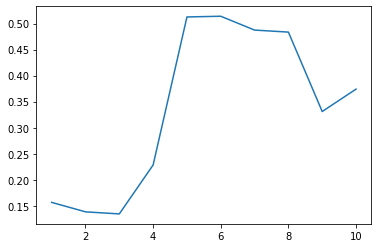

In [57]:
X_train = resampled_df[predictor_list]
y_train = resampled_df['Crash_Sev_ID']
X_test = test[predictor_list]
y_test = test['Crash_Sev_ID']

max_depths = np.linspace(1, 10, 10, endpoint=True)
train_results = []

for max_depth in max_depths:
   dt = DecisionTreeClassifier(criterion="entropy", max_depth=max_depth)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_test)
   train_pred_score = metrics.accuracy_score(y_test, train_pred)
   train_results.append(train_pred_score)
   print(max_depth)

from matplotlib.legend_handler import HandlerLine2D
line1 = plt.plot(max_depths, train_results)
plt.show()

In [62]:
X_train = resampled_df[predictor_list]
y_train = resampled_df['Crash_Sev_ID']
X_test = test[predictor_list]
y_test = test['Crash_Sev_ID']

In [60]:
dtc = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
dtc.fit(X_train,y_train)
y_hat = dtc.predict(X_test)

In [61]:
f1_score(y_test, y_hat, average=None)

array([0.10551274, 0.10853331, 0.13684211, 0.08466899, 0.72002551])

In [63]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
y_hat=clf.predict(X_test)

In [64]:
f1_score(y_test, y_hat, average=None)

array([0.06516854, 0.14866113, 0.22860985, 0.17575758, 0.78291706])

In [75]:
recall_score(y_test, y_hat, average=None)

array([0.04041812, 0.11324072, 0.19573978, 0.12083333, 0.85409408])

In [71]:
rfc=RandomForestClassifier(random_state=42)

In [72]:
param_grid = { 
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [73]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
CV_rfc.best_params_